In [1]:
import random

import torch
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import numpy.linalg as LA
import pandas as pd
import jax.numpy.linalg as JLA

### Load the images

In [3]:
jacob_filename = 'jacob_64px_202474.pkl'
size = 64
jacob = torch.load("jacobians/"+jacob_filename)
# input_cropped_64_474 = torch.load("jacobians/input_cropped_64px_202474.pkl")
# filled_center_64_474 = torch.load("jacobians/filled_center_64px_202476.pkl")
# jacob_64_535 = torch.load("jacobians/jacob_64px_202476.pkl")
# input_cropped_64_535 = torch.load("jacobians/input_cropped_64px_202476.pkl")
# jacob_16_474 = torch.load("jacobians/jacob_16px_202474.pkl")
# input_cropped_16_474 = torch.load("jacobians/input_cropped_16px_202474.pkl")
# filled_center_16_474 = torch.load("jacobians/filled_center_16px_202476.pkl")
# jacob_16_535 = torch.load("jacobians/jacob_16px_202476.pkl")
# input_cropped_16_535 = torch.load("jacobians/input_cropped_16px_202476.pkl")

jacob = jacob[0,:,:,:,0,:,:,:]
# input_cropped_64_474 = input_cropped_64_474[0,:,:,:]
# filled_center_64_474 = filled_center_64_474[0,:,:,:]
# jacob_64_535 = jacob_64_535[0,:,:,:,0,:,:,:]
# input_cropped_64_535 = input_cropped_64_535[0,:,:,:]
# jacob_16_474 = jacob_16_474[0,:,:,:,0,:,:,:]
# input_cropped_16_474 = input_cropped_16_474[0,:,:,:]
# filled_center_16_474 = filled_center_16_474[0,:,:,:]
# jacob_16_535 = jacob_16_535[0,:,:,:,0,:,:,:]
# input_cropped_16_535 = input_cropped_16_535[0,:,:,:]

print(jacob.shape)

### Flattening A_j for SVD

In [5]:
# For 64x64
# Each row of A_flat is jacob[j,i,k,:,:,:].flatten(), multiplied by input.flatten()
if size = 64:
    A_flat = torch.zeros([12288,49152])
    for j in range(3):
        for i in range(64):
            for k in range(64):
                ix = j*(64*64)+i*64+k
                A_flat[ix,:] = jacob[j,i,k,:,:,:].flatten()
    # A_flat is the flattened Jacobian shape = [12288,49152]
    
elif size= 16:
    # Each row of A_flat is jacob[j,i,k,:,:,:].flatten(), multiplied by input.flatten()
    A_flat = torch.zeros([16*16*3,49152])
    for j in range(3):
        for i in range(16):
            for k in range(16):
                ix = j*(16*16)+i*16+k
                A_flat[ix,:] = jacob[j,i,k,:,:,:].flatten()
    # A_flat is the flattened Jacobian shape = [768,49152]

else:
    print("Invalid size")
    
# Delete jacob to free up memory
del(jacob)            

## SVD

In [19]:
# u,s,vh = JLA.svd(A_flat,full_matrices=False)
abs_sv = abs(s.flatten())
abs_sv.sort()
abs_sv

DeviceArray([1.8530382e+01, 1.3065053e+01, 1.0947923e+01, ...,
             2.3956146e-08, 1.7573061e-08, 1.1775765e-08], dtype=float32)

In [18]:
# abs_sv = abs(s)


(12288,)

Text(0.5, 0, 'Count of singular values')

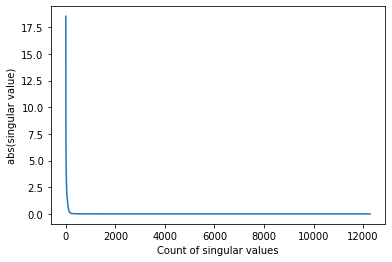

In [20]:
plt.plot(abs_sv)
plt.ylabel("abs(singular value)")
plt.xlabel("Count of singular values")

In [ ]:
# Save sing values
pd.Series(s).to_pickle("jacobians/s_16_535.pkl")

In [ ]:
# Are the right and left singular vectors similar, if eigenvalues are large?


In [22]:
# Cosine between left and right singular vectors (Need to fix)
cosines = []
for i in range(128):
    if abs(s[i])>0.02:
        left = u[:,i]
        right = vh[i,:]
        cos = np.dot(left, right) / (LA.norm(left) * LA.norm(right))
        cosines.append(cos)

ValueError: shapes (12288,) and (49152,) not aligned: 12288 (dim 0) != 49152 (dim 0)

In [ ]:
plt.hist([abs(cos) for cos in cosines])

In [ ]:
channel=0
# Zero out the internal window
jacob_64_474[:,:,:,:,32:96,32:96] = 0
jacob_64_535[:,:,:,:,32:96,32:96] = 0
jacob_16_474[:,:,:,:,56:72,56:72] = 0
jacob_16_535[:,:,:,:,56:72,56:72] = 0

# Normalize each pixels weightings
for i in range(64):
    for j in range(64):
        jacob_64_474[channel,i,j,0,:,:] = jacob_64_474[channel,i,j,0,:,:]/(jacob_64_474[channel,i,j,0,:,:].norm())
        jacob_64_535[channel,i,j,0,:,:] = jacob_64_535[channel,i,j,0,:,:]/(jacob_64_535[channel,i,j,0,:,:].norm())
for i in range(16):
    for j in range(16):
        jacob_16_474[channel,i,j,0,:,:] = jacob_16_474[channel,i,j,0,:,:]/(jacob_16_474[channel,i,j,0,:,:].norm())
        jacob_16_535[channel,i,j,0,:,:] = jacob_16_535[channel,i,j,0,:,:]/(jacob_16_535[channel,i,j,0,:,:].norm())     

## Percent of weight near border

In [ ]:
# Run after the zeroing of the mask
pct_border = 0.35
# For 64x64
inner_64 = int(np.floor(32-pct_border*32))
outer_64 = int(np.floor(96+pct_border*32))

inner_norm = np.linalg.norm(jacob_64_474[channel,32,63,channel,inner_64:outer_64,inner_64:outer_64])
total_norm = np.linalg.norm(jacob_64_474[channel,32,63,channel,:,:])
inner_norm/total_norm

In [ ]:
# Run after the zeroing of the mask
# pct_border = 0.1
# For 64x64
inner_16 = int(np.floor(56-pct_border*56))
outer_16 = int(np.floor(72+pct_border*56))

inner_norm = np.linalg.norm(jacob_16_474[channel,8,15,channel,inner_16:outer_16,inner_16:outer_16])
total_norm = np.linalg.norm(jacob_16_474[channel,8,15,channel,:,:])
inner_norm/total_norm

In [ ]:
jacob_16_474[channel,8,8,channel,inner_16:outer_16,inner_16:outer_16].shape

In [ ]:
plt.plot([0.1,0.25,.35,0.5,1.0],[.903,.936,.953,.975,1],'-o',label='16x16')
plt.plot([0.1,0.25,.35,0.5,1.0],[.523,.740,.819,.905,1],'-o',label='64x64')
plt.ylim(0.5,1)
plt.legend(fontsize=12,title='Mask size',title_fontsize=12)
plt.ylabel(r'$\phi_p$',fontsize=15)
plt.xlabel("p (portion of input image)",fontsize=12)
plt.title("Center pixel",fontsize=12)


# plt.subplot(1,2,2)
# plt.plot([0.1,0.25,.35,0.5,1.0],[0.946,0.967,.976,0.984,1],'-x',label='corner')
# plt.plot([0.1,0.25,.35,0.5,1.0],[.922,.962,.974,.983,1],'-o',label='edge')
# plt.ylim(0.5,1)
# plt.legend(fontsize=12)
# plt.title("16x16 pixel mask",fontsize=12)
# # plt.ylabel(r'$\frac{\Vert A_{inner}\Vert_F}{\Vert A_{total}\Vert_F}$',fontsize=24)
# plt.xlabel("Portion of total input image",fontsize=12)

In [ ]:
# plt.subplot(1,2,1)
plt.plot([0.1,0.25,.35,0.5,1.0],[0.673,0.836,.888,0.931,1],'-x',label='corner')
plt.plot([0.1,0.25,.35,0.5,1.0],[.700,.894,.922,.952,1],'-o',label='edge')
plt.plot([0.1,0.25,.35,0.5,1.0],[.523,.740,.819,.905,1],'-o',label='center')
plt.ylim(0.5,1)
plt.legend(fontsize=12,title='Pixel location',title_fontsize=12)
plt.ylabel(r'$\phi_p$',fontsize=15)
plt.xlabel("p (portion of input image)",fontsize=12)
plt.title("64x64 pixel mask",fontsize=12)


# plt.subplot(1,2,2)
# plt.plot([0.1,0.25,.35,0.5,1.0],[0.946,0.967,.976,0.984,1],'-x',label='corner')
# plt.plot([0.1,0.25,.35,0.5,1.0],[.922,.962,.974,.983,1],'-o',label='edge')
# plt.plot([0.1,0.25,.35,0.5,1.0],[.903,.936,.953,.975,1],'-o',label='center')
# plt.ylim(0.5,1)
# plt.legend(fontsize=12)
# plt.title("16x16 pixel mask",fontsize=12)
# # plt.ylabel(r'$\frac{\Vert A_{inner}\Vert_F}{\Vert A_{total}\Vert_F}$',fontsize=24)
# plt.xlabel("Portion of total input image",fontsize=12)

## Combined Image

In [2]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [ ]:
vmin = -.15
vmax = .15
cmap=plt.cm.bwr
px0 = [0,0] 
px1 = [8,8] # Center
px2 = [32,32] # Eyes?
px3 = [32,63] # Other eye
px4 = [0,0] 
px5 = [3,3] # Center
px6 = [8,8] # Eyes?
px7 = [8,15] # Other eye

channel = 0
titles = ['#1']

fig, axes = plt.subplots(nrows=2, ncols=4,figsize=[25,18])
for i,px,ax in zip(range(4),[px0,px1,px2,px3],axes.flat):
    im = ax.imshow(jacob_64_535[channel,px[0],px[1],0,:,:],cmap=cmap,norm=MidpointNormalize(midpoint=0,vmin=vmin, vmax=vmax))
    ax.set_title("64x64 mask: "+str(px),fontsize=15)
for i,px,ax in zip(range(4,8),[px4,px5,px6,px7],axes.flat[4:]):
    im = ax.imshow(jacob_16_535[channel,px[0],px[1],0,:,:],cmap=cmap,norm=MidpointNormalize(midpoint=0,vmin=vmin, vmax=vmax))
    ax.set_title("16x16 mask: "+str(px),fontsize=15)
   
    
fig.colorbar(im, orientation='horizontal',shrink=0.9,aspect=70,pad=0.05,ax=axes.ravel().tolist())

plt.show()

### Pixel impact - 64x64

In [ ]:
# px0 = [0,63] 
# px1 = [16,16] # Center
# px2 = [32,32] # Eyes?
# px3 = [63,63] # Other eye
# channel = 0
# titles = ['#1']

# fig, axes = plt.subplots(nrows=2, ncols=2,figsize=[15,15])
# for i,px,ax in zip(range(4),[px0,px1,px2,px3],axes.flat):
#     im = ax.imshow(jacob_64_474[channel,px[0],px[1],0,:,:],cmap=cmap,norm=MidpointNormalize(midpoint=0,vmin=vmin, vmax=vmax))
#     ax.set_title("#"+str(i+1))

# fig.colorbar(im, orientation='vertical',ax=axes.ravel().tolist())

# plt.show()

In [ ]:
vmin = -.15
vmax = .15
cmap=plt.cm.bwr
px0 = [0,0] 
px1 = [12,12] 
px2 = [32,32] # Eyes?
px3 = [32,63] # Other eye
channel = 0
titles = ['#1']

fig, axes = plt.subplots(nrows=1, ncols=4,figsize=[25,12])
for i,px,ax in zip(range(4),[px0,px1,px2,px3],axes.flat):
    im = ax.imshow(jacob_64_474[channel,px[0],px[1],0,:,:],cmap=cmap,norm=MidpointNormalize(midpoint=0,vmin=vmin, vmax=vmax))
    ax.set_title(str(px),fontsize=15)
#     ax.set_xlabel("pixel")
#     ax.set_ylabel("pixel")

fig.colorbar(im, orientation='horizontal',shrink=0.9,aspect=70,ax=axes.ravel().tolist())

plt.show()

In [ ]:
vmin = -.15
vmax = .15
cmap=plt.cm.bwr
px0 = [0,0] 
px1 = [12,12] 
px2 = [32,32] # Eyes?
px3 = [32,63] # Other eye
channel = 0
titles = ['#1']

fig, axes = plt.subplots(nrows=1, ncols=4,figsize=[25,12])
for i,px,ax in zip(range(4),[px0,px1,px2,px3],axes.flat):
    im = ax.imshow(jacob_64_535[channel,px[0],px[1],0,:,:],cmap=cmap,norm=MidpointNormalize(midpoint=0,vmin=vmin, vmax=vmax))
    ax.set_title(str(px),fontsize=15)
#     ax.set_xlabel("pixel")
#     ax.set_ylabel("pixel")

fig.colorbar(im, orientation='horizontal',shrink=0.9,aspect=70,ax=axes.ravel().tolist())

plt.show()

In [ ]:
# Plot the cropped and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=[15,15])
axes.flat[0].imshow(input_cropped_64_474[0,:,:])

### 16X16 image

In [ ]:
vmin = -.15
vmax = .15
cmap=plt.cm.bwr
px0 = [0,0] 
px1 = [3,3] # Center
px2 = [8,8] # Eyes?
px3 = [8,15] # Other eye
channel = 0
titles = ['#1']

fig, axes = plt.subplots(nrows=1, ncols=4,figsize=[25,12])
for i,px,ax in zip(range(4),[px0,px1,px2,px3],axes.flat):
    im = ax.imshow(jacob_16_474[channel,px[0],px[1],0,:,:],cmap=cmap,norm=MidpointNormalize(midpoint=0,vmin=vmin, vmax=vmax))
    ax.set_title(str(px),fontsize=15)

fig.colorbar(im, orientation='horizontal',shrink=0.9,aspect=70,ax=axes.ravel().tolist())

plt.show()

In [ ]:
vmin = -.15
vmax = .15
cmap=plt.cm.bwr
px0 = [0,0] 
px1 = [3,3] # Center
px2 = [8,8] # Eyes?
px3 = [8,15] # Other eye
channel = 0
titles = ['#1']

fig, axes = plt.subplots(nrows=1, ncols=4,figsize=[25,12])
for i,px,ax in zip(range(4),[px0,px1,px2,px3],axes.flat):
    im = ax.imshow(jacob_16_535[channel,px[0],px[1],0,:,:],cmap=cmap,norm=MidpointNormalize(midpoint=0,vmin=vmin, vmax=vmax))
    ax.set_title(str(px),fontsize=15)

fig.colorbar(im, orientation='horizontal',shrink=0.9,aspect=70,ax=axes.ravel().tolist())

plt.show()

### Other image

In [ ]:
vmin = 0
vmax = abs(jacob_64_535).max()*0.2
norm = colors.Normalize(vmin=vmin, vmax=vmax)

### 16X16 image

In [ ]:
vmin = 0
vmax = abs(jacob_16_535).max()*0.1
norm_16 = colors.Normalize(vmin=vmin, vmax=vmax)

In [ ]:
print("Weight from each input pixel on a specific output pixel")

# Looking for particular features
px0 = [0,0] 
px1 = [0,8] 
px2 = [4,4] 
px3 = [8,0] 
px4 = [8,8] 
px5 = [12,12] 
px6 = [12,4] 
px7 = [15,15]
channel = 0

jacob_16_535[:,:,:,:,56:72,56:72] = 0
fig, ((ax0,ax1,ax2),(ax3, ax4, ax5),(ax6,ax7,ax8)) = plt.subplots(3, 3, figsize=(20,20))

ax0.set_title("Pixel "+str(px0))
ax1.set_title("Pixel "+str(px1))
ax2.set_title("Pixel "+str(px2))
ax3.set_title("Pixel "+str(px3))
ax4.set_title("Pixel "+str(px4))
ax5.set_title("Pixel "+str(px5))
ax6.set_title("Pixel "+str(px6))
ax7.set_title("Pixel "+str(px7))
ax8.set_title("Input Image")

im = ax0.imshow(abs(jacob_16_535[channel,px0[0],px0[1],0,:,:]),cmap='binary').set_norm(norm_16)
im = ax1.imshow(abs(jacob_16_535[channel,px1[0],px1[1],0,:,:]),cmap='binary').set_norm(norm_16)
im = ax2.imshow(abs(jacob_16_535[channel,px2[0],px2[1],0,:,:]),cmap='binary').set_norm(norm_16)
im = ax3.imshow(abs(jacob_16_535[channel,px3[0],px3[1],0,:,:]),cmap='binary').set_norm(norm_16)
im = ax4.imshow(abs(jacob_16_535[channel,px4[0],px4[1],0,:,:]),cmap='binary').set_norm(norm_16)
im = ax5.imshow(abs(jacob_16_535[channel,px5[0],px5[1],0,:,:]),cmap='binary').set_norm(norm_16)
im = ax6.imshow(abs(jacob_16_535[channel,px6[0],px6[1],0,:,:]),cmap='binary').set_norm(norm_16)
im = ax7.imshow(abs(jacob_16_535[channel,px7[0],px7[1],0,:,:]),cmap='binary').set_norm(norm_16)
im = ax8.imshow(input_cropped_16_535[channel,:,:])

# fig.colorbar(im7,ax=im7,orientation='horizontal', fraction=.1)